# Hyperparameter tuning with XGBoost, Ray Tune, Hyperopt and Optuna

## Introduction


In this post we are going to demonstrate how we can speed up hyperparameter tuning with:

1) Bayesian optimization tuning algos like HyperOpt and Optuna, running on…

2) the [Ray](https://ray.io/) distributed ML framework, with a [unified API to many hyperparameter search algos](https://medium.com/riselab/cutting-edge-hyperparameter-tuning-with-ray-tune-be6c0447afdf) with early stopping and…

3) a distributed cluster of cloud instances for even more speedup.

### Outline:
- Overview of hyperparameter tuning
- Baseline linear regression with no hyperparameters
- ElasticNet with L1 and L2 regularization using ElasticNetCV hyperparameter optimization
- ElasticNet with GridSearchCV hyperparameter optimization
- XGBoost: sequential grid search over hyperparameter subsets with early stopping 
- XGBoost: with HyperOpt and Optuna search algorithms
- LightGBM: with HyperOpt and Optuna search algorithms
- XGBoost: HyperOpt on a Ray cluster
- LightGBM: HyperOpt on a Ray cluster
- Concluding remarks
18735

But first, here are results on the Ames housing data set, predicting Iowa home prices:

| ML Algo           | Hyperparameter search algo   | CV Error (RMSE in $)  | Time     |
|-------------------|------------------------------|-----------------------|----------|
| XGB               | Sequential Grid Search       | 18783                |   36:09  |
| XGB               | HyperOpt (128 samples)       | 18770                | 13:36 |
| XGB               | Optuna (256 samples)         | 18722                | 43:21 |
| LightGBM          | HyperOpt (256 samples)       | 18612              |   45:08  |
| LightGBM          | Optuna                       |  18534               |  | 34:54
| XGB               | Optuna - 16-instance cluster | 18770                |   14:23  |
| LightGBM          | Optuna - 16-instance cluster | 18612                |    4:22  |
| Baseline:         |                              |
| Linear Regression | --                           | 18192                |   0:01s  |
| ElasticNet        | ElasticNetCV (Grid Search)   | 18122                |   0:02s  |          
| ElasticNet        | GridSearchCV                 | 18061                |   0:05s  |          

We see both speedup and RMSE improvement when using HyperOpt and Optuna, and the cluster. But our feature engineering was quite good and our simple linear model still outperforms boosting. (Not shown, SVR and KR are high-performing and an ensemble improves over all individual algos)


## Hyperparameter Tuning Overview

Here are [the principal approaches to hyperparameter tuning](https://en.wikipedia.org/wiki/Hyperparameter_optimization)

- Grid search: given a finite set of discrete values for each hyperparameter, exhaustively cross-validate all combinations

- Random search: given a discrete or continuous distribution for each hyperparameter, randomly sample from the joint distribution. Generally [more efficient than exhaustive grid search.](https://dl.acm.org/doi/10.5555/2188385.2188395 ) 

- Bayesian optimization: update the search space as you go based on outcomes of prior searches.

- Gradient-based optimization: attempt to estimate the gradient of the CV metric with respect to the hyperparameter and ascend/descend the gradient.

- Evolutionary optimization: sample the search space, discard combinations with poor metrics, and genetically evolve new combinations to try based on the successful combinations.

- Population-based: A method of performing hyperparameter optimization at the same time as training.

In this post we focus on Bayesian optimization with HyperOpt and Optuna. What is Bayesian optimization? When we perform a grid search, the search space can be considered a prior belief that the best hyperparameter vector is in the search space, and the combinations have equal probability of being the best combination. So we try them all and pick the best one.

Perhaps we might do two passes of grid search. After an initial search on a broad, coarsely spaced grid, we might do a deeper dive in a smaller area around the best metric from the first pass, with a more finely-spaced grid. In Bayesian terminology we updated our prior belief.

Bayesian optimization first samples randomly, e.g. 30 combinations, and computes the cross-validation metric for each combination. Then the algorithm updates the distribution it samples from, so it is more likely to sample combinations near the good metrics, and less likely to sample combinations near the poor metrics. As it continues to sample, it continues to update the search distribution based on the metrics it finds.

Early stopping may also highly beneficial: often we can discard a combination without fully training it. In this post we use [ASHA](https://arxiv.org/abs/1810.05934). 

We use 4 regression algorithms:
- LinearRegression: baseline with no hyperparameters
- ElasticNet: Linear regression with L1 and L2 regularization (2 hyperparameters).
- XGBoost
- LightGBM

We use 5 approaches :
- *Native CV*: In sklearn if an algo has hyperparameters it will often have an xxxCV version which performs automated hyperparameter tuning over a search space with specified kfolds.
- *GridSearchCV*: Abstracts CV for any sklearn algo, running multithreaded trials over specified folds. 
- *Manual sequential grid search*: What we typically do with XGBoost, which doesn't play well with GridSearchCV and has too many hyperparameters to tune in one pass.
- *Ray on local machine*: HyperOpt and Optuna with early stopping.
- *Ray on cluster*: Additionally scale out to run a single hyperparameter optimization task over many instances.

We use data from the Ames Housing Dataset https://www.kaggle.com/c/house-prices-advanced-regression-techniques . The original data has 79 raw features. The data we will use has 100 features with a fair amount of feature engineering from [my own attempt at modeling](https://github.com/druce/iowa), which was in the top 5% or so when I submitted it to Kaggle.

### Further reading: 
 - [Hyper-Parameter Optimization: A Review of Algorithms and Applications](https://arxiv.org/abs/2003.05689) Tong Yu, Hong Zhu (2020)
 - [Hyperparameter Search in Machine Learning](https://arxiv.org/abs/1502.02127v2), Marc Claesen, Bart De Moor (2015)
 - [Hyperparameter Optimization](https://link.springer.com/chapter/10.1007/978-3-030-05318-5_1), Matthias Feurer, Frank Hutter (2019) 

In [58]:
from itertools import product
from datetime import datetime, timedelta
import os
import random
import string

import numpy as np
import pandas as pd

import sklearn
from sklearn.linear_model import LinearRegression, ElasticNet, ElasticNetCV, Ridge, RidgeCV
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV, KFold
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.decomposition import PCA

#!conda install -y -c conda-forge  xgboost 
import xgboost
from xgboost import XGBRegressor
from xgboost import plot_importance

import lightgbm
from lightgbm import LGBMRegressor

import ray
from ray import tune
from ray.tune.suggest import ConcurrencyLimiter
from ray.tune.schedulers import AsyncHyperBandScheduler
from ray.tune.suggest.hyperopt import HyperOptSearch
from ray.tune.suggest.optuna import OptunaSearch
from ray.tune.logger import DEFAULT_LOGGERS

# wandb.com is great for real-time tracking but not necessary
# beautiful charts but JS UI is sometimes a bit cursed
# cloud reporting latency can slow down tuning
import wandb
from ray.tune.integration.wandb import WandbLogger
from ray.tune.integration.wandb import wandb_mixin
from wandb.lightgbm import wandb_callback
os.environ['WANDB_NOTEBOOK_NAME']='hyperparameter_optimization'
os.environ["WANDB_RUN_GROUP"] = "experiment-" + wandb.util.generate_id()

print(datetime.now())

print ("%-20s %s"% ("numpy", np.__version__))
print ("%-20s %s"% ("pandas", pd.__version__))
print ("%-20s %s"% ("sklearn", sklearn.__version__))
print ("%-20s %s"% ("xgboost", xgboost.__version__))
print ("%-20s %s"% ("lightgbm", lightgbm.__version__))
print ("%-20s %s"% ("ray", ray.__version__))

pd.set_option('max_colwidth', 1000)


2020-10-20 09:37:58.279854
numpy                1.19.1
pandas               1.1.3
sklearn              0.23.2
xgboost              1.2.0
lightgbm             2.3.0
ray                  1.0.0


In [59]:
# set seed for reproducibility
RANDOMSTATE = 42
np.random.seed(RANDOMSTATE)


In [60]:
# import train data
df = pd.read_pickle('df_train.pickle')

response = 'SalePrice'
predictors = ['YearBuilt',
              'BsmtFullBath',
              'FullBath',
              'KitchenAbvGr',
              'GarageYrBlt',
              'LotFrontage',
              'MasVnrArea',
              '1stFlrSF',
              'GrLivArea',
              'GarageArea',
              'WoodDeckSF',
              'PorchSF',
              'AvgBltRemod',
              'FireBathRatio',
              'TotalSF x OverallQual x OverallCond',
              'AvgBltRemod x Functional x TotalFinSF',
              'Functional x OverallQual',
              'KitchenAbvGr x KitchenQual',
              'GarageCars x GarageYrBlt',
              'GarageQual x GarageCond x GarageCars',
              'HeatingQC x Heating',
              'monthnum',
              'log_YearBuilt',
              'log_LotArea',
              'log_TotalFinSF',
              'log_GarageRatio',
              'log_TotalSF x OverallQual x OverallCond',
              'log_TotalSF x OverallCond',
              'log_AvgBltRemod x TotalFinSF',
              'sq_2ndFlrSF',
              'sq_BsmtFinSF',
              'sq_BsmtFinSF x BsmtQual',
              'sq_BsmtFinSF x BsmtBath',
              'BldgType_4',
              'BsmtExposure_1',
              'BsmtExposure_4',
              'BsmtFinType1_1',
              'BsmtFinType1_2',
              'BsmtFinType1_4',
              'BsmtFinType1_5',
              'BsmtFinType1_6',
              'CentralAir_0',
              'CentralAir_1',
              'Condition1_1',
              'Condition1_3',
              'ExterCond_2',
              'ExterQual_2',
              'Exterior1st_4',
              'Exterior1st_5',
              'Exterior1st_10',
              'Fence_0',
              'Fence_2',
              'Foundation_1',
              'Foundation_5',
              'GarageCars_1',
              'GarageFinish_2',
              'GarageFinish_3',
              'GarageType_2',
              'HouseStyle_2',
              'KitchenQual_4',
              'LotConfig_0',
              'LotConfig_4',
              'MSSubClass_30',
              'MSSubClass_70',
              'MSZoning_0',
              'MSZoning_1',
              'MSZoning_4',
              'MasVnrType_2',
              'MasVnrType_3',
              'MoSold_1',
              'MoSold_5',
              'MoSold_6',
              'MoSold_11',
              'Neighborhood_3',
              'Neighborhood_4',
              'Neighborhood_5',
              'Neighborhood_10',
              'Neighborhood_11',
              'Neighborhood_16',
              'Neighborhood_17',
              'Neighborhood_19',
              'Neighborhood_22',
              'Neighborhood_24',
              'OverallCond_7',
              'OverallQual_5',
              'OverallQual_6',
              'OverallQual_7',
              'OverallQual_9',
              'PavedDrive_0',
              'PavedDrive_2',
              'SaleCondition_1',
              'SaleCondition_2',
              'SaleCondition_5',
              'SaleType_4',
              'BedroomAbvGr_1',
              'BedroomAbvGr_4',
              'BedroomAbvGr_5',
              'HalfBath_1',
              'TotalBath_1.0',
              'TotalBath_2.5']

display(df[predictors].head())
display(df[[response]].head())


,YearBuilt,BsmtFullBath,FullBath,KitchenAbvGr,GarageYrBlt,LotFrontage,MasVnrArea,1stFlrSF,GrLivArea,GarageArea,...,SaleCondition_1,SaleCondition_2,SaleCondition_5,SaleType_4,BedroomAbvGr_1,BedroomAbvGr_4,BedroomAbvGr_5,HalfBath_1,TotalBath_1.0,TotalBath_2.5
Id,,,,,,,,,,,,,,,,,,,,,
1,7,1,2,1,7,65.0,196.0,856,1710,548.0,...,0,0,0,1,0,0,0,1,0,0
2,34,0,2,1,34,80.0,0.0,1262,1262,460.0,...,0,0,0,1,0,0,0,0,0,1
3,9,1,2,1,9,68.0,162.0,920,1786,608.0,...,0,0,0,1,0,0,0,1,0,0
4,95,1,1,1,12,60.0,0.0,961,1717,642.0,...,1,0,0,1,0,0,0,0,0,0
5,10,1,2,1,10,84.0,350.0,1145,2198,836.0,...,0,0,0,1,0,1,0,1,0,0


,SalePrice
Id,
1,12.247699
2,12.109016
3,12.317171
4,11.849405
5,12.429220


In [61]:
# we are training on a response which is the log of 1 + the sale price
# transform prediction back to original basis with expm1 and evaluate vs. original

MEAN_RESPONSE=df[response].mean()
def cv_to_raw(cv_val, mean_response=MEAN_RESPONSE):
    """convert log1p rmse to underlying SalePrice error"""
    # MEAN_RESPONSE assumes folds have same mean response, which is true in expectation but not in each fold
    # we can also pass the actual response for each fold
    # but we're usually looking to consistently convert the log value to a more meaningful unit
    return np.expm1(mean_response+cv_val) - np.expm1(mean_response)

In [62]:
# always use same k-folds for reproducibility
kfolds = KFold(n_splits=10, shuffle=True, random_state=RANDOMSTATE)


## Baseline linear regression
- Raw CV RMSE 18191.9791

In [7]:
%%time
# Tune lr search space for alphas and l1_ratio
print("LinearRegression")

print(len(predictors), "predictors")

lr = LinearRegression()

# evaluate using kfolds
scores = -cross_val_score(lr, df[predictors], df[response],
                          scoring="neg_root_mean_squared_error",
                          cv=kfolds,
                          n_jobs=-1)
raw_scores = [cv_to_raw(x) for x in scores]
print()
print("Log1p CV RMSE %.04f (STD %.04f)" % (np.mean(scores), np.std(scores)))
print("Raw CV RMSE %.0f (STD %.0f)" % (np.mean(raw_scores), np.std(raw_scores)))


LinearRegression
100 predictors

Log1p CV RMSE 0.1037 (STD 0.0099)
Raw CV RMSE 18192 (STD 1839)
CPU times: user 72 ms, sys: 76 ms, total: 148 ms
Wall time: 1.04 s


## Native Sklearn xxxCV
- LogisticRegressionCV, LassoCV, RidgeCV, ElasticNetCV, etc.
- Test many hyperparameters in parallel with multithreading
- Note improvement vs. LinearRegression due to controlling overfitting
- RMSE $18103
- Time 5s


In [8]:
%%time
# Tune elasticnet search space for alphas and L1_ratio
# predictor selection used to create the training set used lasso
# so l1 parameter is close to 0
# could use ridge (eg elasticnet with 0 L1 regularization)
# but then only 1 param, more general and useful to do this with elasticnet
print("ElasticnetCV")

# make pipeline
# with regularization must scale predictors
elasticnetcv = make_pipeline(RobustScaler(),
                             ElasticNetCV(max_iter=100000, 
                                          l1_ratio=[0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99],
                                          alphas=np.logspace(-4, -2, 9),
                                          cv=kfolds,
                                          n_jobs=-1,
                                          verbose=1,
                                         ))

#train and get hyperparams
elasticnetcv.fit(df[predictors], df[response])
l1_ratio = elasticnetcv._final_estimator.l1_ratio_
alpha = elasticnetcv._final_estimator.alpha_
print('l1_ratio', l1_ratio)
print('alpha', alpha)

# evaluate using kfolds on full dataset
# I don't see API to get CV error from elasticnetcv, so we use cross_val_score
elasticnet = ElasticNet(alpha=alpha,
                        l1_ratio=l1_ratio,
                        max_iter=10000)

scores = -cross_val_score(elasticnet, df[predictors], df[response],
                          scoring="neg_root_mean_squared_error",
                          cv=kfolds,
                          n_jobs=-1)
raw_scores = [cv_to_raw(x) for x in scores]
print()
print("Log1p CV RMSE %.04f (STD %.04f)" % (np.mean(scores), np.std(scores)))
print("Raw CV RMSE %.0f (STD %.0f)" % (np.mean(raw_scores), np.std(raw_scores)))


ElasticnetCV


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
...........................................................................................................................................................................................................................................................................................[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.2s
.............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

l1_ratio 0.01
alpha 0.0031622776601683794

Log1p CV RMSE 0.1030 (STD 0.0109)
Raw CV RMSE 18061 (STD 2008)
CPU times: user 5.88 s, sys: 3.35 s, total: 9.23 s
Wall time: 1.53 s


## GridSearchCV
- Useful for algos with no native multithreaded xxxCV
- Test many hyperparameter combinations in parallel with multithreading
- Similar result vs ElasticNetCV, not exact, need more research as to why


In [9]:
%%time
gs = make_pipeline(RobustScaler(),
                   GridSearchCV(ElasticNet(max_iter=100000),
                                param_grid={'l1_ratio': [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99],
                                            'alpha': np.logspace(-4, -2, 9),
                                           },
                                scoring='neg_root_mean_squared_error',
                                refit=True,
                                cv=kfolds,
                                n_jobs=-1,
                                verbose=1
                               ))

# do cv using kfolds on full dataset
print("\nCV on full dataset")
gs.fit(df[predictors], df[response])
print('best params', gs._final_estimator.best_params_)
print('best score', -gs._final_estimator.best_score_)
l1_ratio = gs._final_estimator.best_params_['l1_ratio']
alpha = gs._final_estimator.best_params_['alpha']
print("Log1p CV RMSE %.06f" % (-gs._final_estimator.best_score_))
print("Raw CV RMSE %.0f" % (cv_to_raw(-gs._final_estimator.best_score_)))

# eval similarly to before
elasticnet = ElasticNet(alpha=alpha,
                        l1_ratio=l1_ratio,
                        max_iter=100000)
print(elasticnet)

scores = -cross_val_score(elasticnet, df[predictors], df[response],
                          scoring="neg_root_mean_squared_error",
                          cv=kfolds,
                          n_jobs=-1)
raw_scores = [cv_to_raw(x) for x in scores]
print()
print("Log1p CV RMSE %.06f (STD %.04f)" % (np.mean(scores), np.std(scores)))
print("Raw CV RMSE %.0f (STD %.0f)" % (np.mean(raw_scores), np.std(raw_scores)))

# difference in average CV scores reported by GridSearchCV and cross_val_score
# with same alpha, l1_ratio, kfolds
# one reason could be that we used simple average, GridSearchCV is weighted by # of samples per fold?
nsamples = [len(z[1]) for z in kfolds.split(df)]
print("weighted average %.06f" % np.average(scores, weights=nsamples))
# still tiny difference, not sure why, also ElasticSearchCV shows fewer fits, takes less time



CV on full dataset
Fitting 10 folds for each of 117 candidates, totalling 1170 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 1170 out of 1170 | elapsed:    4.6s finished


best params {'alpha': 0.0031622776601683794, 'l1_ratio': 0.01}
best score 0.10247177583755482
Log1p CV RMSE 0.102472
Raw CV RMSE 17952
ElasticNet(alpha=0.0031622776601683794, l1_ratio=0.01, max_iter=100000)

Log1p CV RMSE 0.103003 (STD 0.0109)
Raw CV RMSE 18061 (STD 2008)
weighted average 0.103023
CPU times: user 1.98 s, sys: 452 ms, total: 2.43 s
Wall time: 5 s


In [9]:
# roll-our-own CV 
# matches cross_val_score
alpha = 0.0031622776601683794
l1_ratio = 0.01
regressor = ElasticNet(alpha=alpha,
                       l1_ratio=l1_ratio,
                       max_iter=10000)
print(regressor)
cverrors = []
for train_fold, cv_fold in kfolds.split(df): 
    fold_X_train=df[predictors].values[train_fold]
    fold_y_train=df[response].values[train_fold]
    fold_X_test=df[predictors].values[cv_fold]
    fold_y_test=df[response].values[cv_fold]
    regressor.fit(fold_X_train, fold_y_train)
    y_pred_test=regressor.predict(fold_X_test)
    cverrors.append(np.sqrt(mean_squared_error(fold_y_test, y_pred_test)))
    
print("%.06f" % np.average(cverrors))
    

ElasticNet(alpha=0.0031622776601683794, l1_ratio=0.01, max_iter=10000)
0.103003


In [10]:
# try PCA
pipe = Pipeline(steps=[ ('scaler', RobustScaler()), ('pca', PCA()), ('elasticnet', ElasticNet(max_iter=10000))])

param_grid = {
    'pca__n_components': [5, 10, 15, 25, 50, 100],
    'elasticnet__l1_ratio': [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99],
    'elasticnet__alpha': np.logspace(-4, -2, 9),
}

gs = GridSearchCV(pipe, param_grid,
                  scoring='neg_root_mean_squared_error',
                  refit=True,
                  cv=kfolds,
                  n_jobs=-1,
                  verbose=1)

gs.fit(df[predictors], df[response])
print('best params', gs.best_params_)
print('best score', -gs.best_score_)

pipe = Pipeline(steps=[('scaler', RobustScaler()),
                       ('pca', PCA(n_components=gs.best_params_['pca__n_components'])),  
                       ('elasticnet', ElasticNet(alpha=gs.best_params_['elasticnet__alpha'], 
                                                 l1_ratio=gs.best_params_['elasticnet__l1_ratio'], 
                                                 max_iter=10000))])
scores = -cross_val_score(pipe, df[predictors], df[response],
                          scoring="neg_root_mean_squared_error",
                          cv=kfolds,
                          n_jobs=-1)
raw_scores = [cv_to_raw(x) for x in scores]
print()
print("Log1p CV RMSE %.06f (STD %.04f)" % (np.mean(scores), np.std(scores)))
print("Raw CV RMSE %.0f (STD %.0f)" % (np.mean(raw_scores), np.std(raw_scores)))


Fitting 10 folds for each of 702 candidates, totalling 7020 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 1584 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 2984 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done 4784 tasks      | elapsed:   23.3s
[Parallel(n_jobs=-1)]: Done 6975 tasks      | elapsed:   33.7s
[Parallel(n_jobs=-1)]: Done 7020 out of 7020 | elapsed:   33.9s finished


best params {'elasticnet__alpha': 0.0017782794100389228, 'elasticnet__l1_ratio': 0.1, 'pca__n_components': 100}
best score 0.10225515641215403

Log1p CV RMSE 0.102255 (STD 0.0120)
Raw CV RMSE 17925 (STD 2213)


In [72]:
X_train, X_test, y_train, y_test = train_test_split(df[predictors], df[response],
                                                    test_size=0.2, random_state=RANDOMSTATE)


In [79]:
%%time
gs = GridSearchCV(XGBRegressor(objective='reg:squarederror',
                               n_estimators=1000,
                               random_state=RANDOMSTATE,
                               verbosity=1,
                               n_jobs=1,
                               booster='gbtree',   
                               # early_stopping_rounds=50, #  pass to fit()
                              ),
                  param_grid={'max_depth': [3, 4],
                              'colsample_bylevel' : [0.15, 0.2],
                              'colsample_bytree': [0.2, 0.3],
                              'subsample': [0.2, 0.3],
                              'learning_rate': [0.01, 0.1],
                             },
                  scoring='neg_root_mean_squared_error',
                  refit=True,
                  cv=5,
                  n_jobs=-1,
                  verbose=1
                 )
print(gs)
# do cv using kfolds on full dataset
print("\nCV on train dataset")

X_train, X_test, y_train, y_test = train_test_split(df[predictors], df[response],
                                                    test_size=0.2, random_state=RANDOMSTATE)

gs.fit(X_train, y_train, 
       eval_set=[(X_train, y_train), (X_test, y_test)],
       early_stopping_rounds=50)
print('best params', gs.best_params_)
print('best score', -gs.best_score_)

xgb = XGBRegressor(objective='reg:squarederror',
                   n_estimators=1000,
                   random_state=RANDOMSTATE,
                   verbosity=1,
                   n_jobs=-1,
                   booster='gbtree',   
                   **gs.best_params_)
print(xgb)

scores = -cross_val_score(xgb, df[predictors], df[response],
                          scoring="neg_root_mean_squared_error",
                          cv=kfolds,
                          n_jobs=-1)
raw_scores = [cv_to_raw(x) for x in scores]
print()
print("Log1p CV RMSE %.06f (STD %.04f)" % (np.mean(scores), np.std(scores)))
print("Raw CV RMSE %.0f (STD %.0f)" % (np.mean(raw_scores), np.std(raw_scores)))

# I don't think this actually works because best score is nan and it just returns the first choice

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster='gbtree',
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=1000, n_...
                                    num_parallel_tree=None, random_state=42,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_paramete

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.2s


[0]	validation_0-rmse:11.42066	validation_1-rmse:11.38848
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:11.30721	validation_1-rmse:11.27503
[2]	validation_0-rmse:11.19481	validation_1-rmse:11.16263
[3]	validation_0-rmse:11.08338	validation_1-rmse:11.05121
[4]	validation_0-rmse:10.97325	validation_1-rmse:10.94107
[5]	validation_0-rmse:10.86431	validation_1-rmse:10.83214
[6]	validation_0-rmse:10.75611	validation_1-rmse:10.72394
[7]	validation_0-rmse:10.64905	validation_1-rmse:10.61688
[8]	validation_0-rmse:10.54294	validation_1-rmse:10.51078
[9]	validation_0-rmse:10.43812	validation_1-rmse:10.40596
[10]	validation_0-rmse:10.33455	validation_1-rmse:10.30237
[11]	validation_0-rmse:10.23210	validation_1-rmse:10.19993
[12]	validation_0-rmse:10.13036	validation_1-rmse:10.09820
[13]	validation_0-rmse:10.02961	validation_1-rmse:9.99744
[14]	validation_0-rmse:9.9

[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    0.7s finished


[93]	validation_0-rmse:4.51532	validation_1-rmse:4.48337
[94]	validation_0-rmse:4.47061	validation_1-rmse:4.43865
[95]	validation_0-rmse:4.42664	validation_1-rmse:4.39469
[96]	validation_0-rmse:4.38310	validation_1-rmse:4.35116
[97]	validation_0-rmse:4.33997	validation_1-rmse:4.30802
[98]	validation_0-rmse:4.29733	validation_1-rmse:4.26539
[99]	validation_0-rmse:4.25494	validation_1-rmse:4.22301
[100]	validation_0-rmse:4.21260	validation_1-rmse:4.18068
[101]	validation_0-rmse:4.17084	validation_1-rmse:4.13891
[102]	validation_0-rmse:4.12905	validation_1-rmse:4.09713
[103]	validation_0-rmse:4.08798	validation_1-rmse:4.05607
[104]	validation_0-rmse:4.04746	validation_1-rmse:4.01555
[105]	validation_0-rmse:4.00783	validation_1-rmse:3.97592
[106]	validation_0-rmse:3.96787	validation_1-rmse:3.93598
[107]	validation_0-rmse:3.92832	validation_1-rmse:3.89665
[108]	validation_0-rmse:3.88995	validation_1-rmse:3.85828
[109]	validation_0-rmse:3.85159	validation_1-rmse:3.82011
[110]	validation_0-rm

[235]	validation_0-rmse:1.13304	validation_1-rmse:1.11293
[236]	validation_0-rmse:1.12249	validation_1-rmse:1.10245
[237]	validation_0-rmse:1.11193	validation_1-rmse:1.09214
[238]	validation_0-rmse:1.10119	validation_1-rmse:1.08147
[239]	validation_0-rmse:1.09084	validation_1-rmse:1.07131
[240]	validation_0-rmse:1.08057	validation_1-rmse:1.06115
[241]	validation_0-rmse:1.07040	validation_1-rmse:1.05103
[242]	validation_0-rmse:1.06010	validation_1-rmse:1.04090
[243]	validation_0-rmse:1.05037	validation_1-rmse:1.03136
[244]	validation_0-rmse:1.04052	validation_1-rmse:1.02170
[245]	validation_0-rmse:1.03059	validation_1-rmse:1.01190
[246]	validation_0-rmse:1.02126	validation_1-rmse:1.00259
[247]	validation_0-rmse:1.01148	validation_1-rmse:0.99302
[248]	validation_0-rmse:1.00209	validation_1-rmse:0.98386
[249]	validation_0-rmse:0.99244	validation_1-rmse:0.97435
[250]	validation_0-rmse:0.98305	validation_1-rmse:0.96500
[251]	validation_0-rmse:0.97412	validation_1-rmse:0.95624
[252]	validati

[377]	validation_0-rmse:0.33265	validation_1-rmse:0.32857
[378]	validation_0-rmse:0.33032	validation_1-rmse:0.32643
[379]	validation_0-rmse:0.32774	validation_1-rmse:0.32394
[380]	validation_0-rmse:0.32545	validation_1-rmse:0.32178
[381]	validation_0-rmse:0.32313	validation_1-rmse:0.31959
[382]	validation_0-rmse:0.32046	validation_1-rmse:0.31699
[383]	validation_0-rmse:0.31799	validation_1-rmse:0.31466
[384]	validation_0-rmse:0.31566	validation_1-rmse:0.31245
[385]	validation_0-rmse:0.31319	validation_1-rmse:0.31012
[386]	validation_0-rmse:0.31123	validation_1-rmse:0.30820
[387]	validation_0-rmse:0.30907	validation_1-rmse:0.30615
[388]	validation_0-rmse:0.30688	validation_1-rmse:0.30405
[389]	validation_0-rmse:0.30476	validation_1-rmse:0.30207
[390]	validation_0-rmse:0.30258	validation_1-rmse:0.30004
[391]	validation_0-rmse:0.30062	validation_1-rmse:0.29817
[392]	validation_0-rmse:0.29862	validation_1-rmse:0.29640
[393]	validation_0-rmse:0.29649	validation_1-rmse:0.29443
[394]	validati

[519]	validation_0-rmse:0.15873	validation_1-rmse:0.16757
[520]	validation_0-rmse:0.15811	validation_1-rmse:0.16702
[521]	validation_0-rmse:0.15762	validation_1-rmse:0.16663
[522]	validation_0-rmse:0.15718	validation_1-rmse:0.16628
[523]	validation_0-rmse:0.15658	validation_1-rmse:0.16584
[524]	validation_0-rmse:0.15607	validation_1-rmse:0.16539
[525]	validation_0-rmse:0.15563	validation_1-rmse:0.16505
[526]	validation_0-rmse:0.15522	validation_1-rmse:0.16472
[527]	validation_0-rmse:0.15477	validation_1-rmse:0.16433
[528]	validation_0-rmse:0.15439	validation_1-rmse:0.16405
[529]	validation_0-rmse:0.15390	validation_1-rmse:0.16364
[530]	validation_0-rmse:0.15341	validation_1-rmse:0.16315
[531]	validation_0-rmse:0.15306	validation_1-rmse:0.16287
[532]	validation_0-rmse:0.15245	validation_1-rmse:0.16230
[533]	validation_0-rmse:0.15208	validation_1-rmse:0.16198
[534]	validation_0-rmse:0.15167	validation_1-rmse:0.16162
[535]	validation_0-rmse:0.15139	validation_1-rmse:0.16137
[536]	validati

[661]	validation_0-rmse:0.12261	validation_1-rmse:0.13793
[662]	validation_0-rmse:0.12241	validation_1-rmse:0.13776
[663]	validation_0-rmse:0.12233	validation_1-rmse:0.13771
[664]	validation_0-rmse:0.12221	validation_1-rmse:0.13764
[665]	validation_0-rmse:0.12205	validation_1-rmse:0.13758
[666]	validation_0-rmse:0.12195	validation_1-rmse:0.13752
[667]	validation_0-rmse:0.12184	validation_1-rmse:0.13740
[668]	validation_0-rmse:0.12172	validation_1-rmse:0.13734
[669]	validation_0-rmse:0.12165	validation_1-rmse:0.13726
[670]	validation_0-rmse:0.12151	validation_1-rmse:0.13717
[671]	validation_0-rmse:0.12144	validation_1-rmse:0.13708
[672]	validation_0-rmse:0.12132	validation_1-rmse:0.13699
[673]	validation_0-rmse:0.12124	validation_1-rmse:0.13696
[674]	validation_0-rmse:0.12115	validation_1-rmse:0.13688
[675]	validation_0-rmse:0.12089	validation_1-rmse:0.13674
[676]	validation_0-rmse:0.12079	validation_1-rmse:0.13667
[677]	validation_0-rmse:0.12055	validation_1-rmse:0.13645
[678]	validati

[803]	validation_0-rmse:0.11046	validation_1-rmse:0.12817
[804]	validation_0-rmse:0.11040	validation_1-rmse:0.12813
[805]	validation_0-rmse:0.11034	validation_1-rmse:0.12810
[806]	validation_0-rmse:0.11029	validation_1-rmse:0.12805
[807]	validation_0-rmse:0.11025	validation_1-rmse:0.12800
[808]	validation_0-rmse:0.11019	validation_1-rmse:0.12791
[809]	validation_0-rmse:0.11014	validation_1-rmse:0.12790
[810]	validation_0-rmse:0.11008	validation_1-rmse:0.12785
[811]	validation_0-rmse:0.11002	validation_1-rmse:0.12777
[812]	validation_0-rmse:0.10997	validation_1-rmse:0.12774
[813]	validation_0-rmse:0.10987	validation_1-rmse:0.12767
[814]	validation_0-rmse:0.10984	validation_1-rmse:0.12765
[815]	validation_0-rmse:0.10981	validation_1-rmse:0.12762
[816]	validation_0-rmse:0.10972	validation_1-rmse:0.12752
[817]	validation_0-rmse:0.10966	validation_1-rmse:0.12749
[818]	validation_0-rmse:0.10963	validation_1-rmse:0.12749
[819]	validation_0-rmse:0.10952	validation_1-rmse:0.12742
[820]	validati

[945]	validation_0-rmse:0.10306	validation_1-rmse:0.12317
[946]	validation_0-rmse:0.10303	validation_1-rmse:0.12312
[947]	validation_0-rmse:0.10301	validation_1-rmse:0.12309
[948]	validation_0-rmse:0.10301	validation_1-rmse:0.12312
[949]	validation_0-rmse:0.10299	validation_1-rmse:0.12312
[950]	validation_0-rmse:0.10296	validation_1-rmse:0.12312
[951]	validation_0-rmse:0.10292	validation_1-rmse:0.12309
[952]	validation_0-rmse:0.10286	validation_1-rmse:0.12305
[953]	validation_0-rmse:0.10286	validation_1-rmse:0.12307
[954]	validation_0-rmse:0.10282	validation_1-rmse:0.12306
[955]	validation_0-rmse:0.10280	validation_1-rmse:0.12304
[956]	validation_0-rmse:0.10278	validation_1-rmse:0.12306
[957]	validation_0-rmse:0.10274	validation_1-rmse:0.12307
[958]	validation_0-rmse:0.10271	validation_1-rmse:0.12307
[959]	validation_0-rmse:0.10270	validation_1-rmse:0.12307
[960]	validation_0-rmse:0.10267	validation_1-rmse:0.12305
[961]	validation_0-rmse:0.10264	validation_1-rmse:0.12304
[962]	validati

## XGBoost Sequential Grid Search 
- XGBoost has native multithreading, CV
- XGBoost has many tuning parameters so a complete grid search has an unreasonable number of combinations
- We tune reduced sets sequentially and use early stopping. 

### Tuning methodology
- Set an initial set of starting parameters
- Do 10-fold CV
- Use early stopping to halt training in each fold if no improvement after eg 100 rounds, pick hyperparameters to minimize average error over kfolds
- Tune sequentially on groups of hyperparameters that don't interact too much between groups to reduce combinations
- Tune max_depth and min_child_weight 
- Tune subsample and colsample_bytree
- Tune alpha, lambda and gamma (regularization)
- Tune learning rate: lower learning rate will need more rounds/n_estimators
- Retrain and evaluate on full dataset with best learning rate and best n_estimators (average stopping point over kfolds)

### Notes
- It doesn't seem possible to get XGBoost early stopping and also use GridSearchCV. GridSearchCV doesn't pass the kfolds in a way that XGboost understands for early stopping
- 2 alternative approaches 
    - use native xgboost .cv which understands early stopping but doesn't use sklearn API (uses DMatrix, not np array or dataframe)
    - use sklearn API and roll our own grid search instead of GridSearchCV (used below)
- XGboost terminology differs from sklearn
    - boost_rounds = n_estimators
    - eta = learning_rate
- parameter reference: https://xgboost.readthedocs.io/en/latest/parameter.html
- training reference: https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.training
- times are wall times on an amazon t2.2xlarge instance  
- to set up environment:
    - `conda create --name hyperparam python=3.8`
    - `conda activate hyperparam`
    - `conda install jupyter`
    - `pip install -r requirements.txt`
- round 1 Wall time: 6min 23s
- round 2 Wall time: 19min 22s
- round 3 Wall time: 5min 30s
- round 4 Wall time: 4min 54s
- total time 36:09
- RMSE 18783.117031

In [11]:
BOOST_ROUNDS=50000   # we use early stopping so make this arbitrarily high
EARLY_STOPPING_ROUNDS=100 # stop if no improvement after 100 rounds

def my_cv(df, predictors, response, kfolds, regressor, verbose=False):
    """Roll our own CV 
    train each kfold with early stopping
    return average metric, sd over kfolds, average best round"""
    metrics = []
    best_iterations = []

    for train_fold, cv_fold in kfolds.split(df): 
        fold_X_train=df[predictors].values[train_fold]
        fold_y_train=df[response].values[train_fold]
        fold_X_test=df[predictors].values[cv_fold]
        fold_y_test=df[response].values[cv_fold]
        regressor.fit(fold_X_train, fold_y_train,
                      early_stopping_rounds=EARLY_STOPPING_ROUNDS,
                      eval_set=[(fold_X_test, fold_y_test)],
                      eval_metric='rmse',
                      verbose=verbose
                     )
        y_pred_test=regressor.predict(fold_X_test)
        metrics.append(np.sqrt(mean_squared_error(fold_y_test, y_pred_test)))
        best_iterations.append(regressor.best_iteration)
    return np.average(metrics), np.std(metrics), np.average(best_iterations)

def cv_over_param_dict(df, param_dict, predictors, response, kfolds, verbose=False):
    """given a list of dictionaries of xgb params
    run my_cv on params, store result in array
    return results
    """
    start_time = datetime.now()
    print("%-20s %s" % ("Start Time", start_time))

    results = []

    for i, d in enumerate(param_dict):
        xgb = XGBRegressor(
            objective='reg:squarederror',
            n_estimators=BOOST_ROUNDS,
            random_state=RANDOMSTATE,    
            verbosity=1,
            n_jobs=-1,
            booster='gbtree',   
            **d
        )    

        metric_rmse, metric_std, best_iteration = my_cv(df, predictors, response, kfolds, xgb, verbose=False)    
        results.append([metric_rmse, metric_std, best_iteration, d])
    
        print("%s %3d result mean: %.6f std: %.6f, iter: %.2f" % (datetime.strftime(datetime.now(), "%T"), i, metric_rmse, metric_std, best_iteration))
        
    end_time = datetime.now()
    print("%-20s %s" % ("Start Time", start_time))
    print("%-20s %s" % ("End Time", end_time))
    print(str(timedelta(seconds=(end_time-start_time).seconds)))
    
    results_df = pd.DataFrame(results, columns=['rmse', 'std', 'best_iter', 'param_dict']).sort_values('rmse')
    display(results_df.head())
    
    best_params = results_df.iloc[0]['param_dict']
    return best_params, results_df

In [17]:
%%time
# set initial XGboost parameters
# run round 1 and get max_depth, min_child_weight based on best values 
# update parameters and run round 2 for subsample and colsample_bytree 
# update parameters and run round 3 for learning_rate and best n_iterations
# this is not an exhaustive list but a representative list of most important parameters to tune
# see https://xgboost.readthedocs.io/en/latest/parameter.html for all parameters
# https://sites.google.com/view/lauraepp/parameters

# early_stopping_rounds gives a warning but seems to be used
# seems like XGB doesn't like it when you use sklearn API beyond the basics
# possibly the native .cv might be the way to go

# initial hyperparams
current_params = {
    'max_depth': 5,
    'colsample_bytree': 0.5,
    'colsample_bylevel': 0.5,
    'subsample': 0.5,
    'learning_rate': 0.01,
}

##################################################
# round 1: tune depth , max_leaves
##################################################
max_depths = list(range(2,8))
# max_leavess = [1, 3, 10, 30, 100] #  doesn't matter
# grid_search_dicts = [dict(zip(['max_depth', 'max_leaves'], [a, b])) 
#                      for a,b in product(max_depths, max_leavess)]
grid_search_dicts = [{'max_depth': md} for md in max_depths]
# merge into full param dicts
full_search_dicts = [{**current_params, **d} for d in grid_search_dicts]

# cv and get best params
current_params, results_df = cv_over_param_dict(df, full_search_dicts, predictors, response, kfolds, verbose=False)

Start Time           2020-10-18 11:20:58.365236
11:21:26   0 result mean: 0.108542 std: 0.011448, iter: 2728.90
11:21:54   1 result mean: 0.108123 std: 0.011366, iter: 2225.30
11:22:29   2 result mean: 0.107936 std: 0.011714, iter: 2229.00
11:23:04   3 result mean: 0.108681 std: 0.011357, iter: 1884.00
11:23:41   4 result mean: 0.109373 std: 0.011591, iter: 1729.70
11:24:24   5 result mean: 0.109264 std: 0.011672, iter: 1740.10
Start Time           2020-10-18 11:20:58.365236
End Time             2020-10-18 11:24:24.034127
0:03:25


,rmse,std,best_iter,param_dict
2,0.107936,0.011714,2229.0,"{'max_depth': 4, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.5, 'subsample': 0.5, 'learning_rate': 0.01}"
1,0.108123,0.011366,2225.3,"{'max_depth': 3, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.5, 'subsample': 0.5, 'learning_rate': 0.01}"
0,0.108542,0.011448,2728.9,"{'max_depth': 2, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.5, 'subsample': 0.5, 'learning_rate': 0.01}"
3,0.108681,0.011357,1884.0,"{'max_depth': 5, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.5, 'subsample': 0.5, 'learning_rate': 0.01}"
5,0.109264,0.011672,1740.1,"{'max_depth': 7, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.5, 'subsample': 0.5, 'learning_rate': 0.01}"


CPU times: user 3min 24s, sys: 808 ms, total: 3min 25s
Wall time: 3min 25s


In [18]:
%%time
##################################################
# round 2: tune subsample, colsample_bytree, colsample_bylevel
##################################################
# subsamples = np.linspace(0.01, 1.0, 10)
# colsample_bytrees = np.linspace(0.1, 1.0, 10)
# colsample_bylevel = np.linspace(0.1, 1.0, 10)
# narrower search
subsamples = np.linspace(0.25, 0.75, 11)
colsample_bytrees = np.linspace(0.1, 0.3, 5)
colsample_bylevel = np.linspace(0.1, 0.3, 5)
# subsamples = np.linspace(0.4, 0.9, 11)
# colsample_bytrees = np.linspace(0.05, 0.25, 5)

grid_search_dicts = [dict(zip(['subsample', 'colsample_bytree', 'colsample_bylevel'], [a, b, c])) 
                     for a,b,c in product(subsamples, colsample_bytrees, colsample_bylevel)]
# merge into full param dicts
full_search_dicts = [{**current_params, **d} for d in grid_search_dicts]
# cv and get best params
current_params, results_df = cv_over_param_dict(df, full_search_dicts, predictors, response, kfolds, verbose=False)


Start Time           2020-10-18 11:24:24.051740
11:24:42   0 result mean: 0.107415 std: 0.013652, iter: 3195.50
11:25:00   1 result mean: 0.107415 std: 0.013652, iter: 3195.50
11:25:15   2 result mean: 0.106196 std: 0.014139, iter: 2341.50
11:25:30   3 result mean: 0.106196 std: 0.014139, iter: 2341.50
11:25:43   4 result mean: 0.106210 std: 0.013387, iter: 1991.40
11:26:02   5 result mean: 0.107478 std: 0.014917, iter: 3299.40
11:26:17   6 result mean: 0.106020 std: 0.014010, iter: 2343.20
11:26:31   7 result mean: 0.106835 std: 0.013553, iter: 1999.70
11:26:44   8 result mean: 0.106835 std: 0.013553, iter: 1999.70
11:26:56   9 result mean: 0.107007 std: 0.014161, iter: 1728.80
11:27:10  10 result mean: 0.105374 std: 0.014054, iter: 2195.20
11:27:23  11 result mean: 0.105629 std: 0.013575, iter: 1997.30
11:27:36  12 result mean: 0.106201 std: 0.013386, iter: 1833.70
11:27:48  13 result mean: 0.107130 std: 0.013648, iter: 1669.20
11:28:01  14 result mean: 0.107105 std: 0.013030, iter: 

11:58:26 128 result mean: 0.105778 std: 0.013389, iter: 2405.50
11:58:42 129 result mean: 0.105735 std: 0.012839, iter: 2284.30
11:59:04 130 result mean: 0.106816 std: 0.014234, iter: 3550.30
11:59:22 131 result mean: 0.104776 std: 0.013353, iter: 2696.40
11:59:37 132 result mean: 0.106699 std: 0.013401, iter: 2004.50
11:59:51 133 result mean: 0.106699 std: 0.013401, iter: 2004.50
12:00:08 134 result mean: 0.106125 std: 0.013070, iter: 2192.50
12:00:26 135 result mean: 0.104839 std: 0.014065, iter: 2581.50
12:00:43 136 result mean: 0.105091 std: 0.012543, iter: 2430.80
12:01:00 137 result mean: 0.105268 std: 0.013035, iter: 2261.30
12:01:17 138 result mean: 0.105437 std: 0.012336, iter: 2021.20
12:01:34 139 result mean: 0.106073 std: 0.012405, iter: 2001.10
12:01:51 140 result mean: 0.106061 std: 0.013342, iter: 2562.40
12:02:07 141 result mean: 0.106388 std: 0.013287, iter: 2161.30
12:02:22 142 result mean: 0.106554 std: 0.012658, iter: 1939.70
12:02:40 143 result mean: 0.106346 std: 

12:37:21 257 result mean: 0.105659 std: 0.011889, iter: 2512.20
12:37:39 258 result mean: 0.105659 std: 0.011889, iter: 2512.20
12:37:56 259 result mean: 0.106025 std: 0.012595, iter: 2290.30
12:38:14 260 result mean: 0.105104 std: 0.013379, iter: 2727.60
12:38:31 261 result mean: 0.105822 std: 0.012719, iter: 2374.50
12:38:47 262 result mean: 0.105582 std: 0.012088, iter: 2191.00
12:39:02 263 result mean: 0.106008 std: 0.012499, iter: 1957.80
12:39:23 264 result mean: 0.105867 std: 0.012316, iter: 2478.10
12:39:41 265 result mean: 0.106334 std: 0.013229, iter: 2798.50
12:39:59 266 result mean: 0.106116 std: 0.012265, iter: 2482.30
12:40:16 267 result mean: 0.107133 std: 0.012923, iter: 2221.70
12:40:33 268 result mean: 0.106939 std: 0.012814, iter: 1981.90
12:40:52 269 result mean: 0.106546 std: 0.012301, iter: 2260.30
12:41:08 270 result mean: 0.106271 std: 0.013313, iter: 2243.10
12:41:26 271 result mean: 0.106144 std: 0.012457, iter: 2356.80
12:41:45 272 result mean: 0.106680 std: 

,rmse,std,best_iter,param_dict
36,0.104301,0.012940,2275.1,"{'max_depth': 4, 'colsample_bytree': 0.2, 'colsample_bylevel': 0.15, 'subsample': 0.3, 'learning_rate': 0.01}"
110,0.104553,0.013535,2666.7,"{'max_depth': 4, 'colsample_bytree': 0.2, 'colsample_bylevel': 0.1, 'subsample': 0.45, 'learning_rate': 0.01}"
86,0.104706,0.012578,2203.3,"{'max_depth': 4, 'colsample_bytree': 0.2, 'colsample_bylevel': 0.15, 'subsample': 0.4, 'learning_rate': 0.01}"
61,0.104742,0.012613,2223.6,"{'max_depth': 4, 'colsample_bytree': 0.2, 'colsample_bylevel': 0.15, 'subsample': 0.35, 'learning_rate': 0.01}"
131,0.104776,0.013353,2696.4,"{'max_depth': 4, 'colsample_bytree': 0.15, 'colsample_bylevel': 0.15, 'subsample': 0.5, 'learning_rate': 0.01}"


CPU times: user 1h 17min 31s, sys: 29.9 s, total: 1h 18min 1s
Wall time: 1h 18min 3s


In [19]:
results_df

,rmse,std,best_iter,param_dict
36,0.104301,0.012940,2275.1,"{'max_depth': 4, 'colsample_bytree': 0.2, 'colsample_bylevel': 0.15, 'subsample': 0.3, 'learning_rate': 0.01}"
110,0.104553,0.013535,2666.7,"{'max_depth': 4, 'colsample_bytree': 0.2, 'colsample_bylevel': 0.1, 'subsample': 0.45, 'learning_rate': 0.01}"
86,0.104706,0.012578,2203.3,"{'max_depth': 4, 'colsample_bytree': 0.2, 'colsample_bylevel': 0.15, 'subsample': 0.4, 'learning_rate': 0.01}"
61,0.104742,0.012613,2223.6,"{'max_depth': 4, 'colsample_bytree': 0.2, 'colsample_bylevel': 0.15, 'subsample': 0.35, 'learning_rate': 0.01}"
131,0.104776,0.013353,2696.4,"{'max_depth': 4, 'colsample_bytree': 0.15, 'colsample_bylevel': 0.15, 'subsample': 0.5, 'learning_rate': 0.01}"
...,...,...,...,...
48,0.107545,0.012324,1712.5,"{'max_depth': 4, 'colsample_bytree': 0.3, 'colsample_bylevel': 0.25, 'subsample': 0.3, 'learning_rate': 0.01}"
98,0.107609,0.013368,1730.5,"{'max_depth': 4, 'colsample_bytree': 0.3, 'colsample_bylevel': 0.25, 'subsample': 0.4, 'learning_rate': 0.01}"
19,0.107610,0.012640,1682.4,"{'max_depth': 4, 'colsample_bytree': 0.25, 'colsample_bylevel': 0.3, 'subsample': 0.25, 'learning_rate': 0.01}"
122,0.107800,0.012941,1904.9,"{'max_depth': 4, 'colsample_bytree': 0.3, 'colsample_bylevel': 0.2, 'subsample': 0.45, 'learning_rate': 0.01}"


In [20]:
##### # round 3: tune alpha, lambda
##################################################
#lauraepp says don't touch these unless you know what you're doing ¯\_(ツ)_/¯
#
# reg_alphas = np.logspace(-3, -2, 3)
# reg_lambdas = np.logspace(-2, 1, 4)
# grid_search_dicts = [dict(zip(['reg_alpha', 'reg_lambda'], [a, b])) 
#                      for a,b in product(reg_alphas, reg_lambdas)]
# # merge into full param dicts
# full_search_dicts = [{**current_params, **d} for d in grid_search_dicts]

# # cv and get best params
# current_params, results_df = cv_over_param_dict(df, full_search_dicts, predictors, response, kfolds, verbose=False)

In [21]:
# round 3: learning rate
learning_rates = np.logspace(-3, -1, 5)
grid_search_dicts = [{'learning_rate': lr} for lr in learning_rates]
# merge into full param dicts
full_search_dicts = [{**current_params, **d} for d in grid_search_dicts]

# cv and get best params
current_params, results_df = cv_over_param_dict(df, full_search_dicts, predictors, response, kfolds, verbose=False)


Start Time           2020-10-18 12:42:27.852208
12:44:16   0 result mean: 0.106451 std: 0.013443, iter: 16709.50
12:44:58   1 result mean: 0.105772 std: 0.013051, iter: 6322.10
12:45:13   2 result mean: 0.104301 std: 0.012940, iter: 2275.10
12:45:19   3 result mean: 0.106255 std: 0.011736, iter: 777.70
12:45:22   4 result mean: 0.111745 std: 0.009933, iter: 355.00
Start Time           2020-10-18 12:42:27.852208
End Time             2020-10-18 12:45:22.740593
0:02:54


,rmse,std,best_iter,param_dict
2,0.104301,0.012940,2275.1,"{'max_depth': 4, 'colsample_bytree': 0.2, 'colsample_bylevel': 0.15, 'subsample': 0.3, 'learning_rate': 0.01}"
1,0.105772,0.013051,6322.1,"{'max_depth': 4, 'colsample_bytree': 0.2, 'colsample_bylevel': 0.15, 'subsample': 0.3, 'learning_rate': 0.0031622776601683794}"
3,0.106255,0.011736,777.7,"{'max_depth': 4, 'colsample_bytree': 0.2, 'colsample_bylevel': 0.15, 'subsample': 0.3, 'learning_rate': 0.03162277660168379}"
0,0.106451,0.013443,16709.5,"{'max_depth': 4, 'colsample_bytree': 0.2, 'colsample_bylevel': 0.15, 'subsample': 0.3, 'learning_rate': 0.001}"
4,0.111745,0.009933,355.0,"{'max_depth': 4, 'colsample_bytree': 0.2, 'colsample_bylevel': 0.15, 'subsample': 0.3, 'learning_rate': 0.1}"


In [22]:
%%time

xgb = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=3438,
    random_state=RANDOMSTATE,    
    verbosity=1,
    n_jobs=-1,
    booster='gbtree',   
    **current_params
)    

print(xgb)

scores = -cross_val_score(xgb, df[predictors], df[response],
                          scoring="neg_root_mean_squared_error",
                          cv=kfolds,
                          n_jobs=-1)

raw_scores = [cv_to_raw(x) for x in scores]
print()
print("Log1p CV RMSE %.06f (STD %.04f)" % (np.mean(scores), np.std(scores)))
print("Raw CV RMSE %.0f (STD %.0f)" % (np.mean(raw_scores), np.std(raw_scores)))


XGBRegressor(base_score=None, booster='gbtree', colsample_bylevel=0.15,
             colsample_bynode=None, colsample_bytree=0.2, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=0.01, max_delta_step=None, max_depth=4,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=3438, n_jobs=-1, num_parallel_tree=None,
             random_state=42, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=0.3, tree_method=None,
             validate_parameters=None, verbosity=1)

Log1p CV RMSE 0.103691 (STD 0.0133)
Raw CV RMSE 18193 (STD 2461)
CPU times: user 44 ms, sys: 120 ms, total: 164 ms
Wall time: 4.48 s


## HyperOpt

HyperOpt is a Bayesian optimization algorithm by [James Bergstra et al.](https://conference.scipy.org/proceedings/scipy2013/pdfs/bergstra_hyperopt.pdf)
  - [Home page](http://hyperopt.github.io/hyperopt/)
  - [GitHub](https://github.com/hyperopt/hyperopt)
  - [HyperOpt: Bayesian Hyperparameter Optimization](https://blog.dominodatalab.com/hyperopt-bayesian-hyperparameter-optimization/), Subir Mansukhani (2019)
    

In [40]:
xgb_tune_kwargs = {
    "n_estimators": tune.loguniform(100, 10000),
    "max_depth": tune.randint(0, 5),
    # max_leaves doesn't seem to have any impact on XGBoost but num_leaves does help LGBM, oddly.
    # 'max_leaves': tune.loguniform(1, 1000),    
    "subsample": tune.quniform(0.25, 0.75, 0.01),
    "colsample_bytree": tune.quniform(0.05, 0.5, 0.01),
    "colsample_bylevel": tune.quniform(0.05, 0.5, 0.01),    
    "learning_rate": tune.quniform(-3.0, -1.0, 0.5),
#     "wandb": {
#         "project": "iowa_xgb",
#         "api_key_file": "~/secrets/wandb.txt",
#    }    
}

xgb_tune_params = [k for k in xgb_tune_kwargs.keys() if k != 'wandb']
xgb_tune_params

['n_estimators',
 'max_depth',
 'subsample',
 'colsample_bytree',
 'colsample_bylevel',
 'learning_rate']

In [41]:
# refactor to give ray.tune a single function of hyperparameters to optimize

# @wandb_mixin
def my_xgb(config):
    
    # fix these configs to match calling convention
    # search wants to pass in floats but xgb wants ints
    #config['max_leaves'] = int(config['max_leaves'])
    config['n_estimators'] = int(config['n_estimators'])   # pass float eg loguniform distribution, use int
    # hyperopt needs left to start at 0 but we want to start at 2    
    config['max_depth'] = int(config['max_depth']) + 2
    config['learning_rate'] = 10 ** config['learning_rate']
    
    xgb = XGBRegressor(
        objective='reg:squarederror',
        n_jobs=1,
        random_state=RANDOMSTATE,
        booster='gbtree',   
        scale_pos_weight=1, 
        **config,
    )
    scores = -cross_val_score(xgb, df[predictors], df[response],
                                      scoring="neg_root_mean_squared_error",
                                      cv=kfolds)
    rmse = np.mean(scores)
    tune.report(rmse=rmse)
#     wandb.log({"rmse": rmse})
    
    return {"rmse": rmse}


In [8]:
# set each to run for about 1 hour for comparability
NUM_SAMPLES=1024

start_time = datetime.now()
print("%-20s %s" % ("Start Time", start_time))

algo = HyperOptSearch(random_state_seed=RANDOMSTATE)
# to limit number of cores, uncomment and set max_concurrent 
# algo = ConcurrencyLimiter(algo, max_concurrent=10)
scheduler = AsyncHyperBandScheduler()

analysis = tune.run(my_xgb,
                    num_samples=NUM_SAMPLES,
                    config=xgb_tune_kwargs,                    
                    name="hyperopt_xgb",
                    metric="rmse",
                    mode="min",
                    search_alg=algo,
                    scheduler=scheduler,
                    verbose=1,
#                     loggers=DEFAULT_LOGGERS + (WandbLogger, ),
                   )

end_time = datetime.now()
print("%-20s %s" % ("Start Time", start_time))
print("%-20s %s" % ("End Time", end_time))
print(str(timedelta(seconds=(end_time-start_time).seconds)))

Trial name,status,loc,colsample_bylevel,colsample_bytree,learning_rate,max_depth,n_estimators,subsample,iter,total time (s),rmse
my_xgb_0c9e6734,TERMINATED,,0.36,0.16,0.00149561,4,4626.62,0.48,1,64.5956,0.115363
my_xgb_0c9e6735,TERMINATED,,0.07,0.47,0.00455539,3,2853.98,0.46,1,33.0195,0.107704
my_xgb_0c9e6736,TERMINATED,,0.08,0.44,0.0798818,1,5842.93,0.67,1,69.3145,0.109746
my_xgb_0c9e6737,TERMINATED,,0.09,0.11,0.00110121,2,6877.73,0.47,1,59.2943,0.149682
my_xgb_0c9e6738,TERMINATED,,0.09,0.29,0.0403208,3,220.67,0.66,1,2.8992,0.116273
my_xgb_0c9e6739,TERMINATED,,0.37,0.46,0.0270039,1,751.724,0.65,1,15.0457,0.109189
my_xgb_0c9e673a,TERMINATED,,0.49,0.3,0.0400602,2,7563.79,0.62,1,134.367,0.1085
my_xgb_0c9e673b,TERMINATED,,0.22,0.35,0.0027847,0,3554.09,0.56,1,41.5801,0.115962
my_xgb_0c9e673c,TERMINATED,,0.07,0.2,0.0473492,4,6918.6,0.52,1,79.7786,0.108683
my_xgb_0c9e673d,TERMINATED,,0.15,0.22,0.00678644,1,2519.09,0.73,1,25.8477,0.108231


Start Time           2020-10-19 09:36:08.910836
End Time             2020-10-19 10:43:11.065013
1:07:02


In [9]:
param_cols = ['config.' + k for k in xgb_tune_params]
analysis_results_df = analysis.results_df[['rmse', 'date', 'time_this_iter_s'] + param_cols].sort_values('rmse')
analysis_results_df


,rmse,date,time_this_iter_s,config.n_estimators,config.max_depth,config.subsample,config.colsample_bytree,config.colsample_bylevel,config.learning_rate
trial_id,,,,,,,,,
0c9e675c,0.104383,2020-10-19_09-40-29,91.218358,9833,2,0.42,0.18,0.14,0.008882
0fe3ef93,0.104893,2020-10-19_09-50-14,41.793491,4455,2,0.43,0.43,0.08,0.014922
0eb03e85,0.105189,2020-10-19_09-45-26,34.692781,3137,2,0.43,0.41,0.12,0.015365
12473179,0.105211,2020-10-19_09-54-41,40.312178,3922,2,0.45,0.42,0.10,0.011416
0c9e674a,0.105324,2020-10-19_09-39-51,99.956236,9229,2,0.41,0.17,0.30,0.010195
...,...,...,...,...,...,...,...,...,...
0d7ebfb0,9.881103,2020-10-19_09-43-41,1.389575,140,6,0.71,0.09,0.23,0.001104
2dba32ae,9.945724,2020-10-19_10-38-05,1.269528,109,4,0.28,0.26,0.32,0.001360
1d0056f8,10.049825,2020-10-19_10-15-28,1.130890,104,4,0.27,0.28,0.32,0.001325


In [12]:
best_config = {z: analysis_results_df.iloc[0]['config.' + z] for z in xgb_tune_params}

xgb = XGBRegressor(
    objective='reg:squarederror',
    random_state=RANDOMSTATE,    
    verbosity=1,
    n_jobs=-1,
    **best_config
)
print(xgb)

scores = -cross_val_score(xgb, df[predictors], df[response],
                          scoring="neg_root_mean_squared_error",
                          cv=kfolds)

raw_scores = [cv_to_raw(x) for x in scores]
print()
print("Log1p CV RMSE %.06f (STD %.04f)" % (np.mean(scores), np.std(scores)))
print("Raw CV RMSE %.0f (STD %.0f)" % (np.mean(raw_scores), np.std(raw_scores)))


XGBRegressor(base_score=None, booster=None, colsample_bylevel=0.14,
             colsample_bynode=None, colsample_bytree=0.18, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=0.008881565699348032, max_delta_step=None,
             max_depth=2, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=9833, n_jobs=-1,
             num_parallel_tree=None, random_state=42, reg_alpha=None,
             reg_lambda=None, scale_pos_weight=None, subsample=0.42,
             tree_method=None, validate_parameters=None, verbosity=1)

Log1p CV RMSE 0.104383 (STD 0.0135)
Raw CV RMSE 18321 (STD 2479)


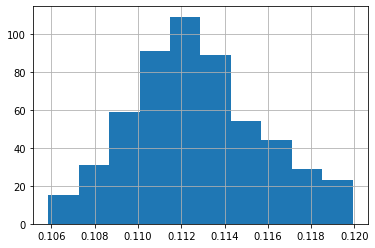

In [53]:
# charts - histogram of RMSEs
analysis_results_df.loc[analysis_results_df['rmse'] < 0.12]['rmse'].hist();

In [54]:
analysis_results_df.reset_index(inplace=True)


In [55]:
# pick combination of hyperparameters with best combination but use caution if they are oddball parameters 'island' of good metric
# one can make a case for doing a convolution, picking the parameter combination such that mean of its metric + all adjacent matrics is minimized
# if one parameter is on the boundary of the search space, expand the search space

def groupby_report(col, myfilter=0.2):
    retarray = analysis_results_df.loc[analysis_results_df['rmse'] < myfilter][[col, 'rmse']] \
        .groupby(col) \
        .mean()
    display(retarray)
    return(retarray)

groupby_report('config.max_depth')
groupby_report('config.subsample')
groupby_report('config.colsample_bytree')
groupby_report('config.colsample_bylevel')
groupby_report('config.n_estimators')
groupby_report('config.learning_rate')

,rmse
config.max_depth,
0,0.121075
1,0.129543
2,0.124263
3,0.120199
4,0.120133
5,0.121525


KeyError: "['config.subsample'] not in index"

In [28]:
# 4096 iterations
config_4096 = {'n_estimators': 2534,
 'max_depth': 3,
 'max_leaves': 22,
 'subsample': 0.42,
 'colsample_bytree': 0.14,
 'colsample_bylevel': 0.21,
 'learning_rate': 0.025422975168222197}

xgb = XGBRegressor(
    objective='reg:squarederror',
    random_state=RANDOMSTATE,    
    verbosity=1,
    n_jobs=-1,
    **config_4096
)
print(xgb)

scores = -cross_val_score(xgb, df[predictors], df[response],
                          scoring="neg_root_mean_squared_error",
                          cv=kfolds)

raw_scores = [cv_to_raw(x) for x in scores]
print()
print("Log1p CV RMSE %.06f (STD %.04f)" % (np.mean(scores), np.std(scores)))
print("Raw CV RMSE %.0f (STD %.0f)" % (np.mean(raw_scores), np.std(raw_scores)))


XGBRegressor(base_score=None, booster=None, colsample_bylevel=0.21,
             colsample_bynode=None, colsample_bytree=0.14, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=0.025422975168222197, max_delta_step=None,
             max_depth=3, max_leaves=22, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=2534, n_jobs=-1,
             num_parallel_tree=None, random_state=42, reg_alpha=None,
             reg_lambda=None, scale_pos_weight=None, subsample=0.42,
             tree_method=None, validate_parameters=None, verbosity=1)

Log1p CV RMSE 0.103816 (STD 0.0130)
Raw CV RMSE 18215 (STD 2393)


## Optuna

Optuna is a Bayesian optimization algorithm by [Takuya Akiba, et al.](https://arxiv.org/abs/1907.10902)

 - [Home](https://optuna.org/)
 - [Using Optuna to Optimize XGBoost Hyperparameters](https://medium.com/optuna/using-optuna-to-optimize-xgboost-hyperparameters-63bfcdfd3407), Crissman Loomis, 2020



In [42]:
# optuna
NUM_SAMPLES=1024

start_time = datetime.now()
print("%-20s %s" % ("Start Time", start_time))

algo = OptunaSearch()
# uncomment and set max_concurrent to limit number of cores
# algo = ConcurrencyLimiter(algo, max_concurrent=10)
scheduler = AsyncHyperBandScheduler()

# identical tune args
analysis = tune.run(my_xgb,
                    num_samples=NUM_SAMPLES,
                    config=xgb_tune_kwargs,                    
                    name="optuna_xgb",
                    metric="rmse",
                    mode="min",
                    search_alg=algo,
                    scheduler=scheduler,
                    verbose=1,
#                     loggers=DEFAULT_LOGGERS + (WandbLogger, ),
                   )

end_time = datetime.now()
print("%-20s %s" % ("Start Time", start_time))
print("%-20s %s" % ("End Time", end_time))
print(str(timedelta(seconds=(end_time-start_time).seconds)))

Trial name,status,loc,colsample_bylevel,colsample_bytree,learning_rate,max_depth,n_estimators,subsample,iter,total time (s),rmse
my_xgb_61a4bb12,TERMINATED,,0.4,0.43,-2,4,1207.27,0.72,1,32.6125,0.110437
my_xgb_61a4bb13,TERMINATED,,0.2,0.43,-3,0,3393.85,0.64,1,39.915,0.425239
my_xgb_61a4bb14,TERMINATED,,0.29,0.07,-1,3,204.205,0.54,1,2.77963,0.115262
my_xgb_61a4bb15,TERMINATED,,0.37,0.28,-2.5,2,9361.76,0.74,1,161.189,0.106378
my_xgb_61a4bb16,TERMINATED,,0.07,0.12,-2.5,5,419.285,0.69,1,3.05796,3.08363
my_xgb_61a4bb17,TERMINATED,,0.2,0.2,-3,2,2240.3,0.31,1,19.9954,1.26713
my_xgb_61a4bb18,TERMINATED,,0.41,0.25,-1,2,3803.81,0.48,1,60.1721,0.113005
my_xgb_61a4bb19,TERMINATED,,0.47,0.37,-3,2,291.012,0.62,1,3.65313,8.62373
my_xgb_61a4bb1a,TERMINATED,,0.05,0.16,-2,5,5740.58,0.55,1,64.9573,0.10532
my_xgb_61a4bb1b,TERMINATED,,0.29,0.13,-3,3,709.262,0.56,1,7.27055,5.68746


Start Time           2020-10-19 11:18:46.107605
End Time             2020-10-19 12:04:43.913330
0:45:57


In [43]:
param_cols = ['config.' + k for k in xgb_tune_params]
analysis_results_df = analysis.results_df[['rmse', 'date', 'time_this_iter_s'] + param_cols].sort_values('rmse')
analysis_results_df

,rmse,date,time_this_iter_s,config.n_estimators,config.max_depth,config.subsample,config.colsample_bytree,config.colsample_bylevel,config.learning_rate
trial_id,,,,,,,,,
61a4bb3c,0.103618,2020-10-19_11-21-12,64.483514,6179,4,0.43,0.20,0.11,0.010000
61a4bb8c,0.104218,2020-10-19_11-24-09,47.113300,3967,5,0.43,0.37,0.08,0.010000
62c16fe0,0.104273,2020-10-19_11-38-11,102.931690,8930,6,0.28,0.21,0.11,0.003162
63f1fabe,0.104433,2020-10-19_11-50-57,129.871126,9364,4,0.39,0.23,0.24,0.003162
6653f15e,0.104987,2020-10-19_12-03-30,58.062527,5539,3,0.73,0.12,0.24,0.010000
...,...,...,...,...,...,...,...,...,...
62c17026,10.310278,2020-10-19_11-39-59,1.184045,112,5,0.40,0.38,0.10,0.001000
63f1fadf,10.361376,2020-10-19_11-50-41,1.276051,107,6,0.51,0.14,0.05,0.001000
61a4bbe5,10.361477,2020-10-19_11-27-34,1.082585,107,7,0.48,0.11,0.28,0.001000


In [44]:
best_config = {z: analysis_results_df.iloc[0]['config.' + z] for z in xgb_tune_params}

xgb = XGBRegressor(
    objective='reg:squarederror',
    random_state=RANDOMSTATE,    
    verbosity=1,
    n_jobs=-1,
    **best_config
)
print(xgb)

scores = -cross_val_score(xgb, df[predictors], df[response],
                          scoring="neg_root_mean_squared_error",
                          cv=kfolds)

raw_scores = [cv_to_raw(x) for x in scores]
print()
print("Log1p CV RMSE %.06f (STD %.04f)" % (np.mean(scores), np.std(scores)))
print("Raw CV RMSE %.0f (STD %.0f)" % (np.mean(raw_scores), np.std(raw_scores)))


XGBRegressor(base_score=None, booster=None, colsample_bylevel=0.11,
             colsample_bynode=None, colsample_bytree=0.2, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=0.01, max_delta_step=None, max_depth=4,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=6179, n_jobs=-1, num_parallel_tree=None,
             random_state=42, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=0.43, tree_method=None,
             validate_parameters=None, verbosity=1)

Log1p CV RMSE 0.103618 (STD 0.0132)
Raw CV RMSE 18179 (STD 2431)


# LightGBM with HyperOpt

In [45]:
lgbm_tune_kwargs = {
    "n_estimators": tune.loguniform(100, 10000),
    "max_depth": tune.randint(0, 5),
    'num_leaves': tune.quniform(1, 10, 1.0),               # xgb max_leaves
    "bagging_fraction": tune.quniform(0.5, 0.8, 0.01),    # xgb subsample
    "feature_fraction": tune.quniform(0.05, 0.5, 0.01),   # xgb colsample_bytree
    "learning_rate": tune.quniform(-3.0, -1.0, 0.5),
#     "wandb": {
#         "project": "iowa",
#     }        
}

#print("wandb name:", lgbm_tune_kwargs['wandb']['name'])
lgbm_tune_params = [k for k in lgbm_tune_kwargs.keys() if k != 'wandb']
print(lgbm_tune_params)

['n_estimators', 'max_depth', 'num_leaves', 'bagging_fraction', 'feature_fraction', 'learning_rate']


In [46]:
# @wandb_mixin
def my_lgbm(config):
    
    # fix these configs 
    config['n_estimators'] = int(config['n_estimators'])   # pass float eg loguniform distribution, use int
    config['num_leaves'] = int(2**config['num_leaves'])
    config['learning_rate'] = 10**config['learning_rate']
    
    lgbm = LGBMRegressor(objective='regression',
                         max_bin=200,
                         feature_fraction_seed=7,
                         min_data_in_leaf=2,
                         verbose=-1,
                         n_jobs=1,
                         # these are specified to suppress warnings
                         colsample_bytree=None,
                         min_child_samples=None,
                         subsample=None,
                         **config,
                         # early stopping params, maybe in fit
                         #early_stopping_rounds=early_stopping_rounds,
                         #valid_sets=[xgtrain, xgvalid], valid_names=['train','valid'], evals_result=evals_results
                         #num_boost_round=num_boost_round,
                         )
    
    scores = -cross_val_score(lgbm, df[predictors], df[response],
                              scoring="neg_root_mean_squared_error",
                              cv=kfolds)
    rmse=np.mean(scores)  
    tune.report(rmse=rmse)
    # wandb.log({"rmse": rmse})
    
    return {'rmse': np.mean(scores)}

In [47]:
# tune LightGBM
print("LightGBM")

NUM_SAMPLES=1024

start_time = datetime.now()
print("%-20s %s" % ("Start Time", start_time))

algo = HyperOptSearch(random_state_seed=RANDOMSTATE)
# uncomment and set max_concurrent to limit number of cores
# algo = ConcurrencyLimiter(algo, max_concurrent=10)
scheduler = AsyncHyperBandScheduler()

# lgbm_tune_kwargs['wandb']['name'] = 'hyperopt_' + xgb_tune_kwargs['wandb']['name']

analysis = tune.run(my_lgbm,
                    num_samples=NUM_SAMPLES,
                    config = lgbm_tune_kwargs,
                    name="hyperopt_lgbm",
                    metric="rmse",
                    mode="min",
                    search_alg=algo,
                    scheduler=scheduler,
                    verbose=1,
#                     loggers=DEFAULT_LOGGERS + (WandbLogger, ),
                   )

end_time = datetime.now()
print("%-20s %s" % ("Start Time", start_time))
print("%-20s %s" % ("End Time", end_time))
print(str(timedelta(seconds=(end_time-start_time).seconds)))

Trial name,status,loc,bagging_fraction,feature_fraction,learning_rate,max_depth,n_estimators,num_leaves,iter,total time (s),rmse
my_lgbm_8c78e4ec,TERMINATED,,0.71,0.16,-3,4,4626.62,33.7485,1,37.5592,0.114896
my_lgbm_8c78e4ed,TERMINATED,,0.51,0.47,-2.5,3,2853.98,25.5793,1,23.9472,0.115249
my_lgbm_8c78e4ee,TERMINATED,,0.52,0.44,-1,1,5842.93,364.012,1,14.8208,0.114466
my_lgbm_8c78e4ef,TERMINATED,,0.52,0.11,-3,2,6877.73,31.7409,1,21.319,0.119708
my_lgbm_8c78e4f0,TERMINATED,,0.53,0.29,-1.5,3,220.67,311.647,1,1.49981,0.115158
my_lgbm_8c78e4f1,TERMINATED,,0.72,0.46,-1.5,1,751.724,287.74,1,2.21232,0.118629
my_lgbm_8c78e4f2,TERMINATED,,0.79,0.3,-1.5,2,7563.79,191.492,1,31.5372,0.111968
my_lgbm_8c78e4f3,TERMINATED,,0.62,0.35,-2.5,0,3554.09,92.5782,1,246.648,0.115594
my_lgbm_8c78e4f4,TERMINATED,,0.52,0.2,-1.5,4,6918.6,58.5678,1,51.5652,0.108537
my_lgbm_8c78e4f5,TERMINATED,,0.56,0.22,-2,1,2519.09,758.292,1,5.99064,0.117232


Start Time           2020-10-19 12:10:04.430900
End Time             2020-10-19 12:55:50.875017
0:45:46


In [48]:
param_cols = ['config.' + k for k in lgbm_tune_params]
analysis_results_df = analysis.results_df[['rmse', 'date', 'time_this_iter_s'] + param_cols].sort_values('rmse')
analysis_results_df

,rmse,date,time_this_iter_s,config.n_estimators,config.max_depth,config.num_leaves,config.bagging_fraction,config.feature_fraction,config.learning_rate
trial_id,,,,,,,,,
8fd8c34a,0.105942,2020-10-19_12-19-23,36.354745,5533,4,21,0.58,0.11,0.010000
948dd435,0.106226,2020-10-19_12-26-52,27.253634,6470,3,17,0.76,0.06,0.003162
9f4ba0c3,0.106406,2020-10-19_12-39-45,17.686205,4574,3,71,0.57,0.12,0.010000
96edc8d8,0.106428,2020-10-19_12-30-25,19.956928,4542,3,53,0.56,0.14,0.010000
b257e29f,0.106481,2020-10-19_12-52-16,16.336964,3754,3,74,0.55,0.12,0.010000
...,...,...,...,...,...,...,...,...,...
9a871921,0.365971,2020-10-19_12-33-28,1.374466,100,4,50,0.60,0.35,0.001000
8d63b194,0.368600,2020-10-19_12-14-10,0.912785,100,4,177,0.70,0.16,0.001000
a2dec38d,0.368725,2020-10-19_12-44-01,0.669126,175,2,35,0.73,0.05,0.001000


In [49]:
best_config = {z: analysis_results_df.iloc[0]['config.' + z] for z in lgbm_tune_params}

lgbm = LGBMRegressor(objective='regression',
                     max_bin=200,
                     feature_fraction_seed=7,
                     min_data_in_leaf=2,
                     verbose=-1,
                     **best_config,
                     # early stopping params, maybe in fit
                     #early_stopping_rounds=early_stopping_rounds,
                     #valid_sets=[xgtrain, xgvalid], valid_names=['train','valid'], evals_result=evals_results
                     #num_boost_round=num_boost_round,
                     )
 
print(lgbm)

scores = -cross_val_score(lgbm, df[predictors], df[response],
                          scoring="neg_root_mean_squared_error",
                          cv=kfolds)

raw_scores = [cv_to_raw(x) for x in scores]
print()
print("Log1p CV RMSE %.06f (STD %.04f)" % (np.mean(scores), np.std(scores)))
print("Raw CV RMSE %.0f (STD %.0f)" % (np.mean(raw_scores), np.std(raw_scores)))
raw_scores = [cv_to_raw(x) for x in scores]

LGBMRegressor(bagging_fraction=0.58, feature_fraction=0.11,
              feature_fraction_seed=7, learning_rate=0.01, max_bin=200,
              max_depth=4, min_data_in_leaf=2, n_estimators=5533, num_leaves=21,
              objective='regression', verbose=-1)

Log1p CV RMSE 0.105942 (STD 0.0130)
Raw CV RMSE 18608 (STD 2410)


# LightGBM with Optuna

In [50]:
# tune LightGBM
print("LightGBM")

NUM_SAMPLES=1024

start_time = datetime.now()
print("%-20s %s" % ("Start Time", start_time))

algo = OptunaSearch()
# uncomment and set max_concurrent to limit number of cores
# algo = ConcurrencyLimiter(algo, max_concurrent=10)
scheduler = AsyncHyperBandScheduler()

# lgbm_tune_kwargs['wandb']['name'] = 'optuna_' + xgb_tune_kwargs['wandb']['name']

analysis = tune.run(my_lgbm,
                    num_samples=NUM_SAMPLES,
                    config = lgbm_tune_kwargs,
                    name="optuna_lgbm",
                    metric="rmse",
                    mode="min",
                    search_alg=algo,
                    scheduler=scheduler,
                    verbose=1,
#                     loggers=DEFAULT_LOGGERS + (WandbLogger, ),
                   )

end_time = datetime.now()
print("%-20s %s" % ("Start Time", start_time))
print("%-20s %s" % ("End Time", end_time))
print(str(timedelta(seconds=(end_time-start_time).seconds)))


Trial name,status,loc,bagging_fraction,feature_fraction,learning_rate,max_depth,n_estimators,num_leaves,iter,total time (s),rmse
my_lgbm_fcdcf29a,TERMINATED,,0.5,0.45,-1.5,2,1736.64,34.6819,1,7.82869,0.111879
my_lgbm_fcdcf29b,TERMINATED,,0.74,0.12,-1,5,3652.01,45.0104,1,32.1853,0.111871
my_lgbm_fcdcf29c,TERMINATED,,0.51,0.26,-1,2,188.848,116.344,1,0.966002,0.114701
my_lgbm_fcdcf29d,TERMINATED,,0.69,0.21,-2.5,0,876.023,82.4486,1,40.4887,0.122533
my_lgbm_fcdcf29e,TERMINATED,,0.57,0.12,-1,0,296.027,5.74747,1,1.71413,0.111663
my_lgbm_fcdcf29f,TERMINATED,,0.67,0.49,-2.5,3,7316.13,145.46,1,60.4991,0.111639
my_lgbm_fcdcf2a0,TERMINATED,,0.68,0.35,-2.5,2,236.357,77.3746,1,1.34306,0.262496
my_lgbm_fcdcf2a1,TERMINATED,,0.67,0.25,-1.5,4,146.172,3.19272,1,0.868645,0.137604
my_lgbm_fcdcf2a2,TERMINATED,,0.59,0.2,-3,3,2978.04,738.907,1,15.9959,0.131898
my_lgbm_fcdcf2a3,TERMINATED,,0.6,0.13,-3,1,1821.23,516.979,1,3.3132,0.238159


Start Time           2020-10-19 12:56:09.981938
End Time             2020-10-19 14:11:03.450405
1:14:53


In [51]:
param_cols = ['config.' + k for k in lgbm_tune_params]
analysis_results_df = analysis.results_df[['rmse', 'date', 'time_this_iter_s'] + param_cols].sort_values('rmse')
analysis_results_df

,rmse,date,time_this_iter_s,config.n_estimators,config.max_depth,config.num_leaves,config.bagging_fraction,config.feature_fraction,config.learning_rate
trial_id,,,,,,,,,
006e7a6f,0.105853,2020-10-19_13-36-38,31.982849,8631,3,680,0.55,0.05,0.010000
ff3e956c,0.106001,2020-10-19_13-23-20,4.540283,1334,0,6,0.54,0.07,0.031623
fe0c1019,0.106084,2020-10-19_13-18-13,22.882113,3811,4,13,0.56,0.09,0.010000
fcdcf306,0.106241,2020-10-19_12-59-45,25.975462,3962,4,11,0.51,0.13,0.010000
006e7af8,0.106262,2020-10-19_13-44-34,18.475541,4607,0,6,0.66,0.08,0.010000
...,...,...,...,...,...,...,...,...,...
ff3e95ff,0.374823,2020-10-19_13-31-27,0.514037,103,2,25,0.51,0.12,0.001000
fe0c0fc8,0.374915,2020-10-19_13-12-29,0.586372,126,1,25,0.55,0.29,0.001000
01a00be2,0.374955,2020-10-19_13-47-36,0.610819,123,1,228,0.67,0.39,0.001000


In [52]:
best_config = {z: analysis_results_df.iloc[0]['config.' + z] for z in lgbm_tune_params}

lgbm = LGBMRegressor(objective='regression',
                     max_bin=200,
                     feature_fraction_seed=7,
                     min_data_in_leaf=2,
                     verbosfe=-1,
                     **best_config,
                     # early stopping params, maybe in fit
                     #early_stopping_rounds=early_stopping_rounds,
                     #valid_sets=[xgtrain, xgvalid], valid_names=['train','valid'], evals_result=evals_results
                     #num_boost_round=num_boost_round,
                     )
 
print(lgbm)

scores = -cross_val_score(lgbm, df[predictors], df[response],
                          scoring="neg_root_mean_squared_error",
                          cv=kfolds)

raw_scores = [cv_to_raw(x) for x in scores]
print()
print("Log1p CV RMSE %.06f (STD %.04f)" % (np.mean(scores), np.std(scores)))
print("Raw CV RMSE %.0f (STD %.0f)" % (np.mean(raw_scores), np.std(raw_scores)))
raw_scores = [cv_to_raw(x) for x in scores]

LGBMRegressor(bagging_fraction=0.55, feature_fraction=0.05,
              feature_fraction_seed=7, learning_rate=0.01, max_bin=200,
              max_depth=3, min_data_in_leaf=2, n_estimators=8631,
              num_leaves=680, objective='regression', verbosfe=-1)

Log1p CV RMSE 0.105853 (STD 0.0130)
Raw CV RMSE 18592 (STD 2410)


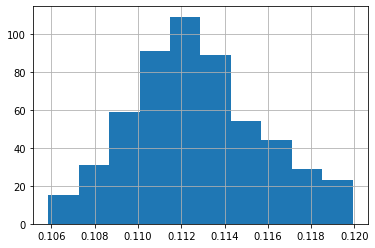

In [56]:
analysis_results_df.loc[analysis_results_df['rmse'] < 0.12]['rmse'].hist();

In [ ]:
analysis_results_df.reset_index(inplace=True)


In [57]:
def groupby_report(col, myfilter=0.2):
    retarray = analysis_results_df.loc[analysis_results_df['rmse'] < myfilter][[col, 'rmse']] \
        .groupby(col) \
        .mean()
    display(retarray)
    return(retarray)

groupby_report('config.max_depth')
groupby_report('config.bagging_fraction')
groupby_report('config.feature_fraction')
groupby_report('config.num_leaves')
groupby_report('config.n_estimators')
groupby_report('config.learning_rate')

,rmse
config.max_depth,
0,0.121075
1,0.129543
2,0.124263
3,0.120199
4,0.120133
5,0.121525


,rmse
config.bagging_fraction,
0.50,0.119567
0.51,0.125388
0.52,0.122906
0.53,0.118453
0.54,0.117428
0.55,0.120367
0.56,0.121073
0.57,0.128418
0.58,0.122105


,rmse
config.feature_fraction,
0.05,0.126200
0.06,0.132698
0.07,0.120875
0.08,0.123911
0.09,0.126330
0.10,0.113792
0.11,0.122447
0.12,0.115286
0.13,0.131610


,rmse
config.num_leaves,
2,0.126809
3,0.126262
4,0.122050
5,0.118532
6,0.126296
...,...
959,0.116555
961,0.124418
973,0.117998


,rmse
config.n_estimators,
101,0.146527
102,0.124029
103,0.118395
104,0.157421
105,0.181188
...,...
9657,0.126909
9752,0.111134
9950,0.131384


,rmse
config.learning_rate,
0.001000,0.140125
0.003162,0.127883
0.010000,0.125706
0.031623,0.117025
0.100000,0.114494


,rmse
config.learning_rate,
0.001000,0.140125
0.003162,0.127883
0.010000,0.125706
0.031623,0.117025
0.100000,0.114494


# Ray Cluster on AWS
(Google Cloud Platform and Azure should be supported as well, see [Ray docs and examples](https://github.com/ray-project/ray/tree/master/python/ray/autoscaler))

- Clusters are defined in `ray1.1.yaml`
- boto3 and AWS CLI configured credentials are used, so [install and configure AWS CLI](https://docs.aws.amazon.com/cli/latest/userguide/cli-chap-install.html)
- Edit `ray1.1.yaml` file with your region, availability zone, subnet, imageid information
    - to get those variables launch the latest Deep Learning AMI (Ubuntu 18.04) Version 35.0 into a small instance in your favorite region/zone
    - test that it works
    - note those 4 variables: region, availability zone, subnet, AMI imageid
    - terminate the instance and edit `ray1.1.yaml` accordingly
    - in future you can create your own image with everything pre-installed and specify its AMI imageid, instead of using the generic image and installing everything at launch.
- To run the cluster: 
`ray up ray1.1.yaml`
    - Creates head instance using image specified.
    - Installs ray and related requirements
    - Clones this Iowa repo
    - Launches worker nodes per auto-scaling parameters (currently we fix the number of nodes because we're not benching the time the cluster will take to auto-scale)
- After cluster starts you can check AWS console and note that several instances launched.
- Check `ray monitor ray1.1.yaml` for any error messages
- Run Jupyter on the cluster with port forwarding
 `ray exec ray1.1.yaml --port-forward=8899 'source ~/anaconda3/bin/activate tensorflow_p36 && jupyter notebook --port=8899'`
- Open the notebook on the generated URL e.g. http://localhost:8899/?token=5f46d4355ae7174524ba71f30ef3f0633a20b19a204b93b4
- Make sure to hoose the default kernel to make sure it runs in the conda environment with all installs
- Make sure to use the ray.init() command given in the startup messages.
- You can also run a terminal on the head node of the cluster with
 `ray attach /Users/drucev/projects/iowa/ray1.1.yaml`
- You can also ssh explicitly with the IP address and the generated private key
 `ssh -o IdentitiesOnly=yes -i ~/.ssh/ray-autoscaler_1_us-east-1.pem ubuntu@54.161.200.54`
- run port forwarding to the Ray dashboard with   
`ray dashboard ray1.1.yaml`
and then open
 http://localhost:8265/
- the cluster will incur AWS charges so `ray down ray1.1.yaml` when complete
- Other than connecting to Ray cluster, runs identically
- see hyperparameter_optimization.ipynb, separated out so each notebook can be run end-to-end with/without cluster setup

see https://docs.ray.io/en/latest/cluster/launcher.html for additional info

## Concluding remarks

We observe a modest but non-negligeable improvement in the target metric with a less manual process vs. sequential tuning.
hyoperopt.optuna yes
ray maybe, depends on further work compare w/optuna and hyperopt online. depends on integration between ray, early stopping and search algo
cluster , in general no need and costs add up. MacBook Pro w/16 threads and desktop with GPU are plenty.

I intend to use HyperOpt and Optuna for xgboost going forward, no more grid search for me! In every case I've applied them, I've gotten at least a small improvement in the best metrics I found using grid search methods. Additionally, it's fire and forget (although with a little elbow grease the 4-pass sequential grid search could be made fire and forget.)

These two algorithms seem to be the most popular but I may try the other algos systematically. 

I am surprised that Elasticnet, i.e. regularized linear regression outperforms boosting. 
This dataset has been heavily engineered so that linear methods work well. Predictors were chosen using lasso/elasticnet and we used log and Box-Cox transforms to force predictors to follow assumptions of least-squares.  

This tends to validate one of the [critiques of machine learning](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3624052), that the most powerful ML methods don't necessarily converge all the way to the best solution. If you have a ground truth that is linear plus noise, a complex XGBoost or neural network algorithm should get arbitrarily close to the closed-form optimal solution but will never match it exactly. XGBoost is piecewise constant and the complex neural network is subject to the vagaries of stochastic gradient descent. 

But Elasticnet with L1 + L2 regularization plus gradient descent and hyperparameter optimization is still machine learning. It's simply the form best matched to the problem. In the real world where things don't match assumptions of least-squares, boosting performs extremely well. And even on this dataset, engineered for the linear models, SVR and KernelRidge performed better than Elasticnet (not shown) and ensembling Elasticnet with XGBoost, LightGBM, SVR, neural networks worked best of all. 

To paraphrase Casey Stengel, clever feature engineering will always outperform clever model algorithms and vice-versa<sup>*</sup>. But improving your hyperparameters with these best practices will always improve your results.

<sup>*</sup>This is not intended to make sense.
